### Conditioning Sparse Variational Gaussian Processes for Online Decision-making, Maddox et al.

In [14]:
import torch

import numpy as np

from gpytorch.mlls import VariationalELBO
from botorch.optim.fit import fit_gpytorch_torch
from gpytorch.kernels import ScaleKernel, MaternKernel

from volatilitygp.models import SingleTaskVariationalGP
from volatilitygp.likelihoods import BernoulliLikelihood

from banana_utils import load_banana_dataset, plot_banana


In [15]:
plot_probability = True  # If False, plot variance, remeber to change vmin and vmax below accordingly
vmin  = 0
vmax = 1

num_inducing = 25

In [16]:
train_x, train_y, test_x, test_y = load_banana_dataset()

# Make batches
ordering = np.argsort(train_x[:,0])

batch_1 = ordering[:100]
batch_2 = ordering[100:200]
batch_3 = ordering[200:300]
batch_4 = ordering[300:]

batches = [batch_1, batch_2, batch_3, batch_4]

In [17]:
init_data = (torch.Tensor(train_x[batch_1]), torch.Tensor(train_y.reshape(-1)[batch_1]))

In [18]:
covar_module = ScaleKernel(MaternKernel())

In [19]:
model = SingleTaskVariationalGP(
    init_points=init_data[0],
    init_targets=init_data[1],
    num_inducing=num_inducing,
    likelihood=BernoulliLikelihood(),
    use_piv_chol_init=True,
    covar_module=covar_module
)

mll = VariationalELBO(model.likelihood, model, num_data=125)

In [20]:
fit_gpytorch_torch(mll);

Iter 10/100: 0.5582969784736633
Iter 20/100: 0.4336696267127991
Iter 30/100: 0.38650447130203247
Iter 40/100: 0.36194777488708496
Iter 50/100: 0.33936768770217896
Iter 60/100: 0.3247362971305847
Iter 70/100: 0.31423419713974
Iter 80/100: 0.3060232400894165
Iter 90/100: 0.2996184527873993
Iter 100/100: 0.29442042112350464


In [21]:
model.covar_module.base_kernel.lengthscale, model.covar_module.outputscale

(tensor([[0.5086]], grad_fn=<SoftplusBackward0>),
 tensor(3.4047, grad_fn=<SoftplusBackward0>))

#### Below values are copied from full trained model so that proposed model and Maddox hyperparameters are same

In [22]:
# model.covar_module.base_kernel.lengthscale = 0.807844
# model.covar_module.outputscale = 2.06925

#### We fit the model above for inducing points to be optimized for batch 1. Can't use the full models Z as every data point in acts as a indcuing variable later on here.

In [23]:
# model.variational_strategy.inducing_points = torch.nn.Parameter(torch.from_numpy(np.array([[-0.9529548446446034, 0.22288086814442867],
#  [1.70041277813756, -0.6020013490324897],
#  [0.8822260604903921, 1.1432721268304753],
#  [-0.40345673067326576, -1.0260725510318582],
#  [-0.7717806687395462, 1.0579383974163494],
#  [1.389177209482708, -1.715494892028588],
#  [1.5280629310804699, 0.2539529637734198],
#  [-0.18829018949241105, 0.6995596766604615],
#  [0.903831759750715, 0.32258177291773577],
#  [0.28851058282526126, 0.21434324595818396],
#  [0.4300033002218921, -0.5811900179365884],
#  [0.4289820203703688, -1.4283404268366662],
#  [1.011705171620295, -0.9853433761114456],
#  [0.33463450232328584, 1.7333903825440413],
#  [0.31407212513522137, 0.8252104007671683],
#  [-0.9344569519621877, -1.091084010073968],
#  [-0.7736892214037306, -0.7992899169171438],
#  [1.1089552300233125, -0.1901801644801258],
#  [-1.6036911691914877, 0.4377537511395932],
#  [-1.6967385745668069, -0.3827509438059443],
#  [1.6249740430390505, 1.3935181571268371],
#  [-0.25473729881884466, -0.4502534525512878],
#  [0.10676188252815139, -0.9465807852843465],
#  [-1.6562657394444704, -1.2248632052104769],
#  [-1.1355087732215574, -0.53102479445226]]).astype(np.float32))
#                                                                )

## Conditioning

In [24]:
def inv_probit(x):
    jitter = 1e-3  # ensures output is strictly between 0 and 1
    return 0.5 * (1.0 + torch.erf(x / np.sqrt(2.0))) * (1 - 2 * jitter) + jitter


def model_predict_old(m, x):
    x = torch.from_numpy(x)
    laplace_post = m.posterior(x, observation_noise=True)
    prob = laplace_post.mean.exp() / (1 + laplace_post.mean.exp())
    
    return laplace_post.mean.detach(), laplace_post.variance.detach(), prob

def model_predict(m, x):
    x = torch.from_numpy(x)
    laplace_post_f = m.posterior(x, observation_noise=True)
    
    prob = laplace_post_f.mean / (1 + torch.sqrt(laplace_post_f.variance))
    prob = inv_probit(prob).detach()
    
    return prob, prob * (1-prob), prob


xtest, ytest = np.mgrid[-2.8:2.8:100j, -2.8:2.8:100j]
Xtest = np.vstack((xtest.flatten(), ytest.flatten())).T
Xtest = Xtest.astype(np.float32)

pred_mu, pred_var, pred_prob = model_predict(model, Xtest)

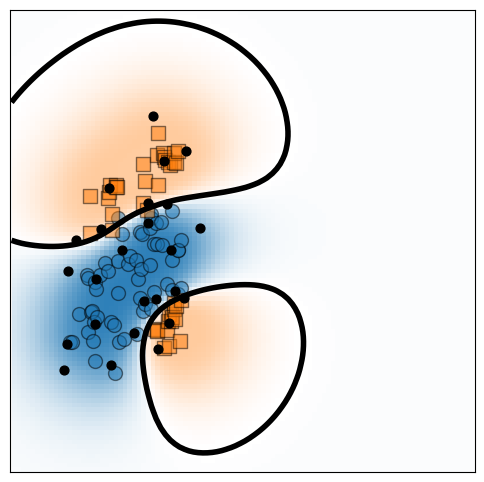

In [25]:
data = (train_x[batch_1], train_y[batch_1][..., None])
inducing_pnts = model.variational_strategy.inducing_points.detach().numpy()

plot_banana(pred_mu, pred_var, pred_prob.detach(), inducing_pnts, data, xtest, ytest, vmin=vmin, vmax=vmax, 
            plot_inducing=True, plot_probability=plot_probability, 
            plot_colorbar=False)


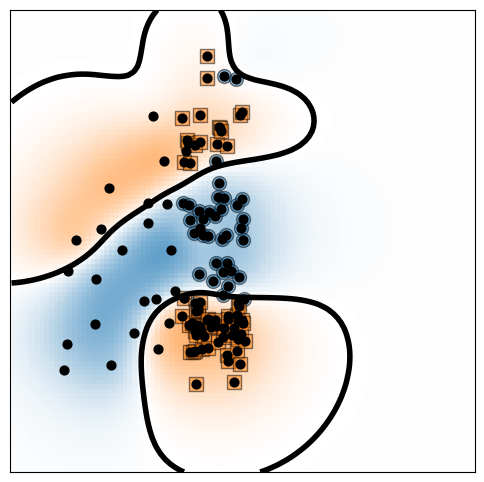

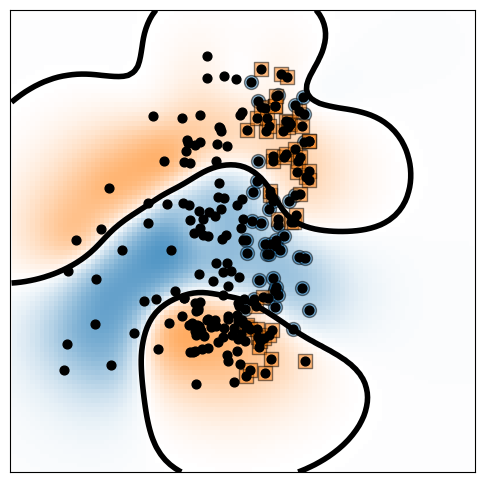

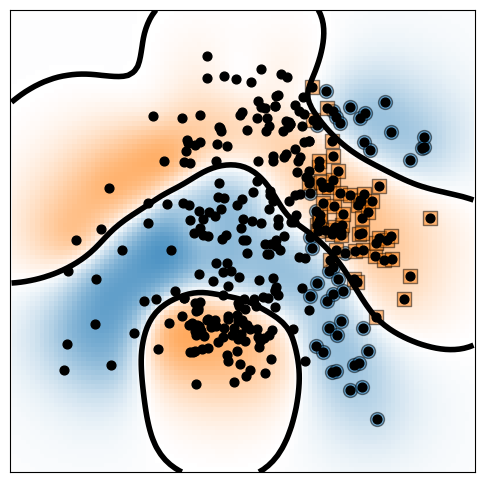

In [26]:
predicted_steps = []
pred_var = []

fant_model = model
new_data_plot = (train_x[batch_1], train_y[batch_1][..., None])

for i in range(1, 4):
    new_data = (torch.Tensor(train_x[batches[i]]), torch.Tensor(train_y[batches[i]]))
    
    if i == 1:
        fant_model = fant_model.get_fantasy_model(new_data[0], new_data[1], targets_are_gaussian=False)
    else:
        targets = model.inducing_model().likelihood.newton_iteration(
            inputs=new_data[0], 
            targets=new_data[1], 
            covar=model.covar_module(new_data[0]),
        )
        
        noise = model.inducing_model().likelihood.neg_hessian_f(targets).diag()
        fant_model = fant_model.get_fantasy_model(new_data[0], targets, noise=noise.reciprocal())

    # For plotting purpose
    new_data_plot_tmp = (train_x[batches[i]], train_y[batches[i]][..., None])
    new_data_plot_0 = new_data_plot_tmp[0] #np.concatenate([new_data_plot[0], new_data_plot_tmp[0]], axis=0)
    new_data_plot_1 = new_data_plot_tmp[1] # np.concatenate([new_data_plot[1], new_data_plot_tmp[1]], axis=0)
    new_data_plot = (new_data_plot_0, new_data_plot_1)
    
    pred_mu, pred_var, pred_prob = model_predict(fant_model, Xtest)
    inducing_pnts = fant_model.train_inputs[0]
    
    if i < 3:
        plot_banana(pred_mu, pred_var, pred_prob.detach(), inducing_pnts, new_data_plot, xtest, ytest, vmin=vmin, vmax=vmax, 
                    plot_inducing=True, plot_probability=plot_probability, 
                    plot_colorbar=False)
    else:
        plot_banana(pred_mu, pred_var, pred_prob.detach(), inducing_pnts, new_data_plot, xtest, ytest, vmin=vmin, vmax=vmax, 
                    plot_inducing=True, plot_probability=plot_probability, 
                    plot_colorbar=False)
    